# Build a Model to Predict Start-up Business Profits

### Problem Statement:

##### Develop a predictive model using the 50 Startups dataset to estimate start-up profits based on key parameters such as R&D spend , administration costs , marketing spend , and state . This model will provide data-driven insights to help investors and entrepreneurs make informed decisions.

### Data Description

##### About 50 business startups were included in this dataset, which was gathered from New York, California, and Florida. Profit, R&D spending, administration spending, and marketing spending are the Features that are used in the dataset.

#### Features
##### R&D Spend | float | Research and Development Expenses 
##### Administration | float | Administration cost
##### Marketing Spend | float | Marketing Expenses
##### State | Object | states like New York, California and Florida

#### Label
##### Profit | float | Profit in startup

# Import necessary libraries

In [4]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display  
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV  
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint 



# Exploratory Data Analysis(EDA) 

In [6]:
#create data Frame  to read dataset
df = pd.read_csv('50_Startups.csv')

In [7]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
 # Check DataFrame structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [9]:
# Generate summary statistics for numerical columns.
df.describe()


,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [10]:
#Checking Duplicates
print('There are',df.duplicated().sum(),'duplicate values in the dateset.') 

There are 0 duplicate values in the dateset.


## Find unwanted Columns

#### The dataset contains no unwanted Columns that need to be removed.

## Find Missing Values

In [14]:
df.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

## Find Features with one value

In [16]:
for column in df.columns:
    print(column,df[column].nunique())

R&D Spend 49
Administration 50
Marketing Spend 48
State 3
Profit 50


 ## Explore the Categorical Features

In [18]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O']
categorical_features

['State']

In [19]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is State and number of categories are 3


## Find Categorical Feature Distribution

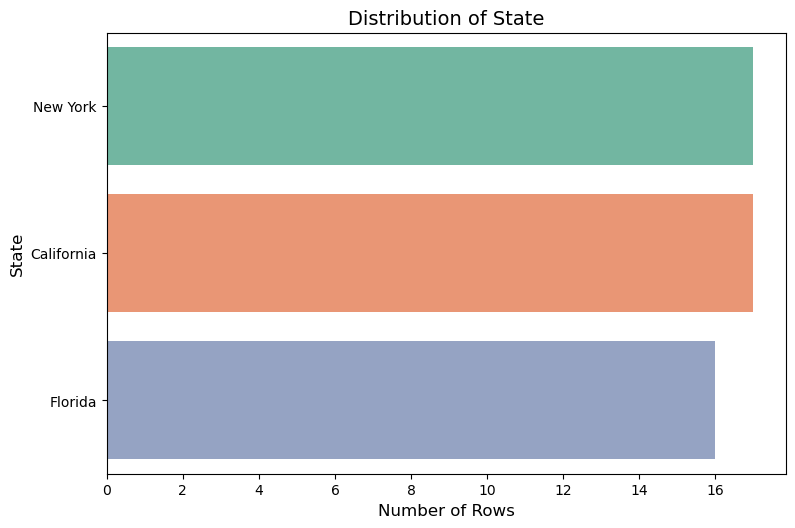

In [21]:
plt.figure(figsize=(15,60), facecolor='white')
plotnumber = 1
for feature in categorical_features:
    ax = plt.subplot(12, 2, plotnumber)
    sns.countplot(y=feature, data=df, hue=feature, palette="Set2", dodge=False)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    plt.xlabel("Number of Rows", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.title(f"Distribution of {feature}", fontsize=14)
    plotnumber += 1

plt.tight_layout()
plt.show()


- State with florida has less number of records 

## Relationship between Categorical Features and Label

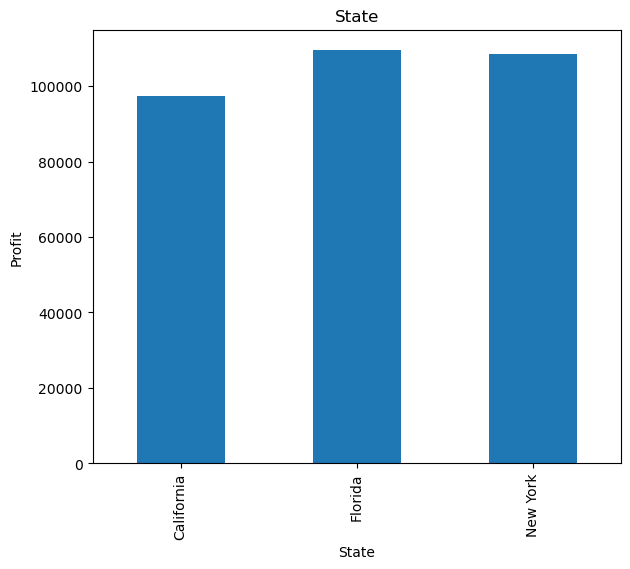

In [24]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for feature in categorical_features:
    ax = plt.subplot(12,2,plotnumber)
    data=df.copy()
    data.groupby(feature)['Profit'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Profit')
    plt.title(feature)
    plotnumber+=1
plt.show()

## Explore the Numerical Features

In [26]:
# list of numerical variables
numerical_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Profit']))]
print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
df[numerical_features].head()

Number of numerical variables:  3


,R&D Spend,Administration,Marketing Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


## Find Discrete Numerical Features

In [28]:
discrete_feature=[feature for feature in numerical_features if len(df[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


## Find Continous Numerical Features

In [30]:
continuous_features=[feature for feature in numerical_features if feature not in discrete_feature+['Profit']]
print("Continuous feature Count {}".format(len(continuous_features)))

Continuous feature Count 3


In [31]:

continuous_features

['R&D Spend', 'Administration', 'Marketing Spend']

## Distribution of Continous Numerical Features

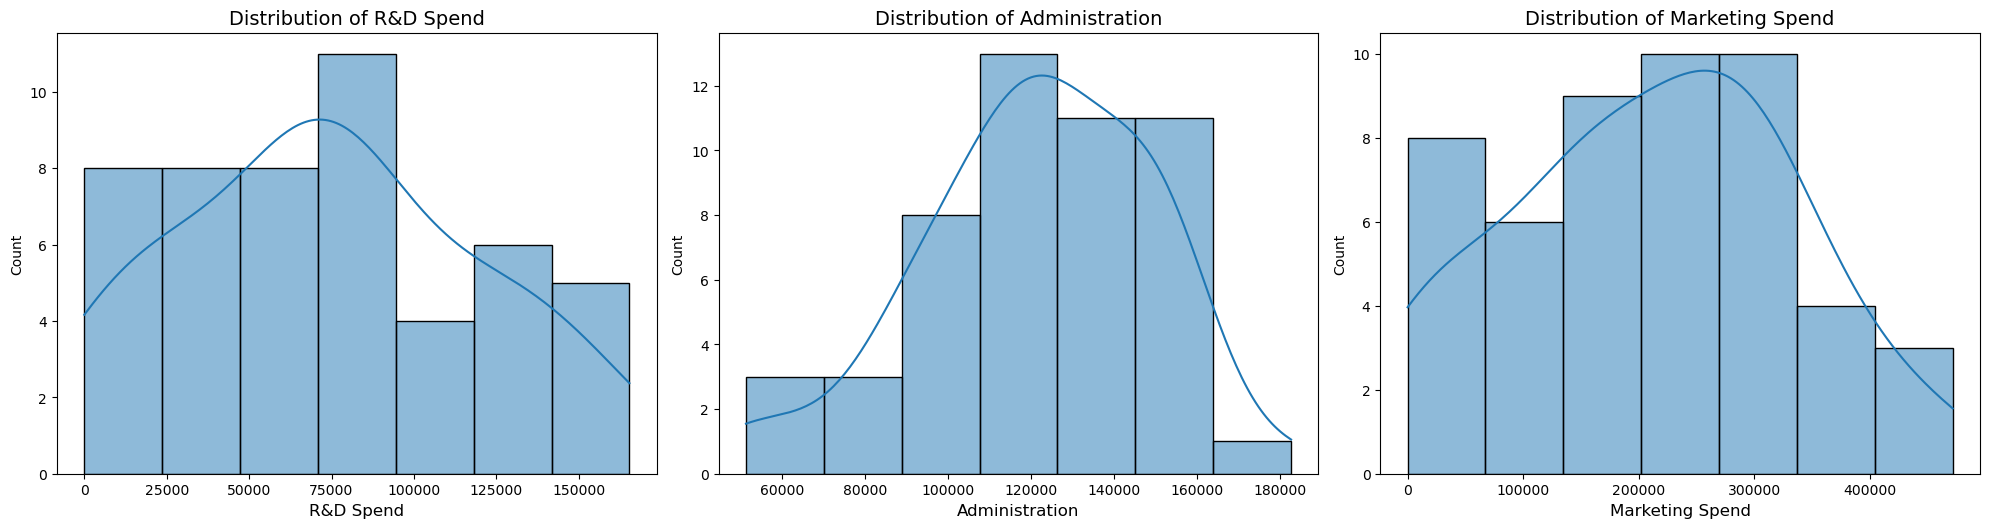

In [33]:
plt.figure(figsize=(20, 60), facecolor='white')
plotnumber = 1

for continuous_feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(data=df, x=continuous_feature, kde=True, ax=ax)
    ax.set_xlabel(continuous_feature, fontsize=12)
    ax.set_title(f"Distribution of {continuous_feature}", fontsize=14)
    plotnumber += 1

plt.tight_layout()
plt.show()


- it seems all continuous features are normally distributed

## Relation between Continous numerical Features and Labels

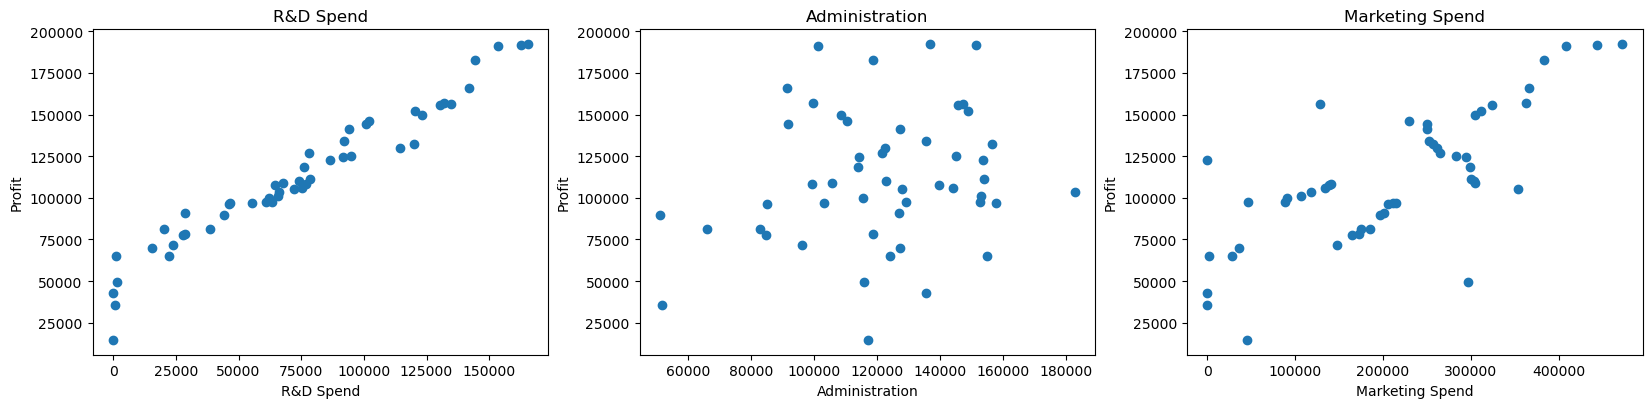

In [36]:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in continuous_features:
    data=df.copy()
    ax = plt.subplot(12,3,plotnumber)
    plt.scatter(data[feature],data['Profit'])
    plt.xlabel(feature)
    plt.ylabel('Profit')
    plt.title(feature)
    plotnumber+=1
plt.show()

## Find Outliers in numerical features

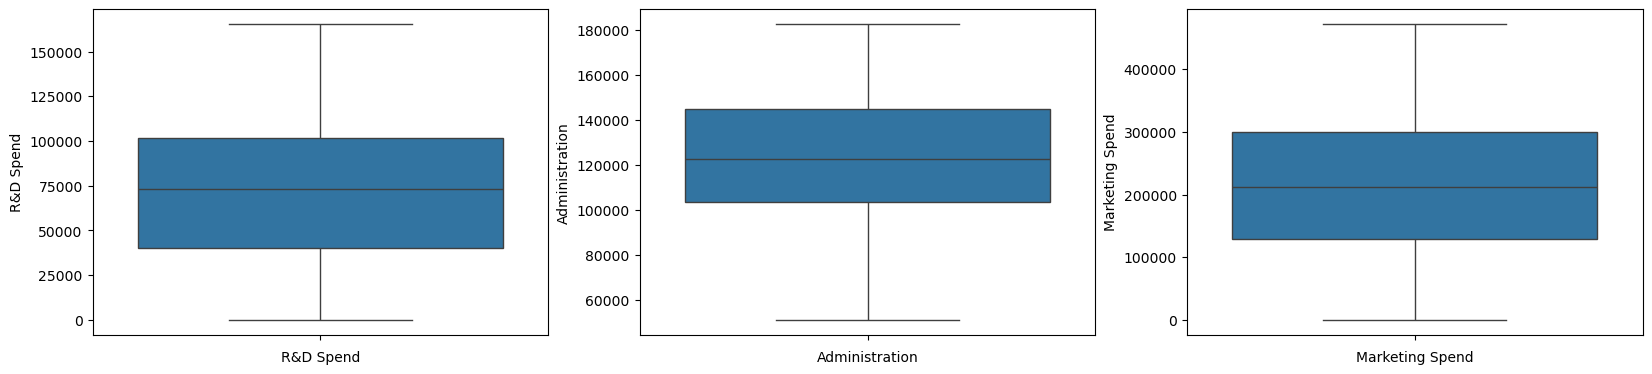

In [38]:
#boxplot on numerical features to find outliers
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for numerical_feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(df[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

## Explore the Correlation between numerical features

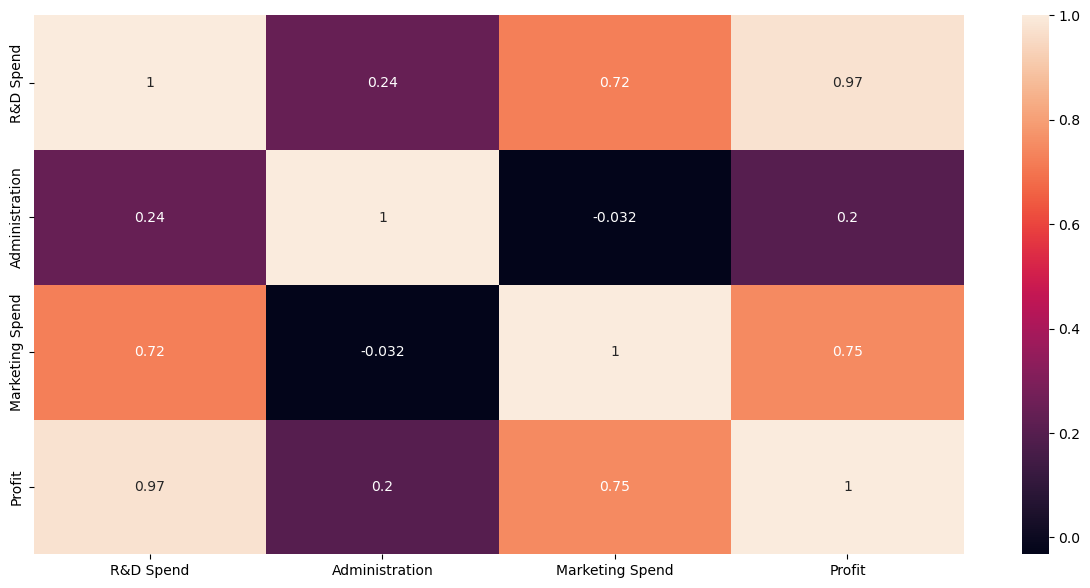

In [40]:
## Checking for correlation
numeric_df = df.select_dtypes(include=['number'])
cor_mat = numeric_df.corr()
fig = plt.figure(figsize=(15,7))
sns.heatmap(cor_mat,annot=True)
plt.show()

# Print Setup

In [42]:
def setup_print():
    print("Print output is set up. All steps will be printed.")


# Helper Function 

In [44]:
def adjusted_r2(r2, n, p):
    """
    Calculate Adjusted R-squared.
    
    Parameters:
        r2 : float - R-squared value.
        n  : int   - Number of observations.
        p  : int   - Number of predictors.
        
    Returns:
        float: Adjusted R-squared value.
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Data Loading Function

In [46]:
def load_data(file_path):
    """
    Load dataset from a CSV file with error handling.
    
    Parameters:
        file_path (str): Path to the CSV file.
        
    Returns:
        DataFrame: Loaded dataset.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with shape {df.shape}")  
        return df
    except Exception as e:
        print(f"Error loading data: {e}") 
        raise

# Preprocessing Setup

In [48]:
def create_preprocessor():
    """
    Create a ColumnTransformer for preprocessing.
    Applies OneHotEncoder on the 'State' column.
    
    Returns:
        ColumnTransformer: Preprocessing transformer.
    """
    categorical_features = ['State']  # Update if additional categorical features exist.
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )
    print("Preprocessor created successfully.")
    return preprocessor


# Pipeline Creation Functions 

In [50]:
def create_pipeline(model, preprocessor):
    """
    Create a pipeline with preprocessing and a given model.
    
    Parameters:
        model: The regression model instance.
        preprocessor: The ColumnTransformer for preprocessing.
        
    Returns:
        Pipeline: The complete pipeline.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    print(f"Pipeline created for {model.__class__.__name__}.")
    return pipeline



In [51]:
def get_pipelines(preprocessor):
    """
    Define and return pipelines for all models.
    
    Returns:
        dict: Dictionary of model pipelines.
    """
    pipelines = {
        "Linear Regression": create_pipeline(LinearRegression(), preprocessor),
        "Ridge Regression": create_pipeline(Ridge(), preprocessor), 
        "Decision Tree Regression": create_pipeline(DecisionTreeRegressor(random_state=42), preprocessor),
        "Random Forest Regression": create_pipeline(RandomForestRegressor(random_state=42), preprocessor),
        "XGBoost Regression": create_pipeline(XGBRegressor(random_state=42, objective='reg:squarederror'), preprocessor)  
    }
    print("All pipelines created successfully.")
    return pipelines



# Hyperparameter Tuning

In [53]:
def tune_hyperparameters(name, pipeline, param_grid, X_train, y_train):
    """
    Tune hyperparameters using GridSearchCV.
    
    Parameters:
        name (str): Name of the model.
        pipeline (Pipeline): The pipeline to be tuned.
        param_grid (dict): Dictionary of parameter grid to search.
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        
    Returns:
        Pipeline: Best estimator from GridSearchCV.
    """
    print(f"Starting hyperparameter tuning for {name} using GridSearchCV...") 
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    return grid_search.best_estimator_


# Cross Validation

In [55]:
def perform_cross_validation(pipelines, X_train, y_train):
    """
    Perform repeated 5-fold cross validation (3 repeats) on each model pipeline.
    
    Parameters:
        pipelines (dict): Dictionary of model pipelines.
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        
    Returns:
        dict: Cross validation results for each model.
    """
    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)  
    cv_results = {}

    print("Performing Repeated 5-fold Cross Validation (3 repeats) on Training Data...")
    for model_name, pipeline in pipelines.items():
        mse_scores, mae_scores, r2_scores, adj_r2_scores = [], [], [], []
        
        for train_index, val_index in rkf.split(X_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            
            # Fit pipeline on the training fold
            pipeline.fit(X_tr, y_tr)
            y_pred = pipeline.predict(X_val)
            
            # Calculate evaluation metrics
            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)
            
            # Compute number of predictors after preprocessing.
            X_val_trans = pipeline.named_steps['preprocessor'].transform(X_val)
            p = X_val_trans.shape[1]
            adj_r2 = adjusted_r2(r2, len(y_val), p)
            
            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)
            adj_r2_scores.append(adj_r2)
        
        cv_results[model_name] = {
            "MSE": np.mean(mse_scores),
            "RMSE": np.mean(np.sqrt(mse_scores)),
            "MAE": np.mean(mae_scores),
            "R2": np.mean(r2_scores),
            "Adjusted R2": np.mean(adj_r2_scores)
        }
        print(f"CV results for {model_name}: {cv_results[model_name]}")
    
    return cv_results



# Test Set Evaluation

In [57]:
def evaluate_on_test(pipelines, X_train, X_test, y_train, y_test):
    """
    Train each pipeline on the full training set and evaluate on the test set.
    
    Returns:
        tuple: (test_results dictionary, predictions dictionary)
    """
    test_results = {}
    predictions = {}

    print("Training each model on the full training set and evaluating on the test set...")
    for model_name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        
        mse_test = mean_squared_error(y_test, y_pred_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Compute number of predictors from transformed training data.
        X_train_trans = pipeline.named_steps['preprocessor'].transform(X_train)
        p_test = X_train_trans.shape[1]
        adj_r2_test = adjusted_r2(r2_test, len(y_test), p_test)
        
        test_results[model_name] = {
            "MSE": mse_test,
            "RMSE": np.sqrt(mse_test),
            "MAE": mae_test,
            "R2": r2_test,
            "Adjusted R2": adj_r2_test
        }
        predictions[model_name] = y_pred_test
        print(f"Test results for {model_name}: {test_results[model_name]}")
    
    return test_results, predictions


# Visualization

In [59]:
def visualize_results(predictions, y_test, test_results):
    """
    Create scatter plots for Actual vs Predicted Profit with enhanced annotations.
    
    Parameters:
        predictions (dict): Dictionary of model predictions on the test set.
        y_test (Series): Actual target values.
        test_results (dict): Evaluation metrics for each model.
    """
    plt.figure(figsize=(16, 12))
    model_names = list(predictions.keys())
    
    for i, model_name in enumerate(model_names, start=1):
        plt.subplot(2, 3, i)
        plt.scatter(y_test, predictions[model_name], color='blue', edgecolor='k', alpha=0.7)
        # Plot the ideal prediction line
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel("Actual Profit")
        plt.ylabel("Predicted Profit")
        plt.title(model_name)
        
       
        metrics = test_results[model_name]
        annotation_text = (
            f"R²: {metrics['R2']:.2f}\n"
            f"Adj R²: {metrics['Adjusted R2']:.2f}\n"
            f"RMSE: {metrics['RMSE']:.2f}\n"
            f"MAE: {metrics['MAE']:.2f}"
        )
        plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction',
                     fontsize=10, backgroundcolor='white', verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    print("Visualization displayed successfully.")

# Summary Table Generation 

In [61]:
def generate_results_table(y_test, predictions):
    """
    Create and display a formatted table comparing the actual values and predictions
    from each model using Pandas styling.
    
    Parameters:
        y_test (Series): Actual target values.
        predictions (dict): Dictionary of model predictions.
    """
    results_df = pd.DataFrame({
        "Actual Value": y_test.to_numpy().flatten()
    })
    for model_name, y_pred in predictions.items():
        results_df[f"{model_name} Predicted"] = y_pred.flatten()
    
    # Round numerical values for better readability
    results_df = results_df.round(2)
    
    # Use Pandas styling to format the table
    styled_df = results_df.style.format("{:.2f}").set_caption("Comparison of Actual vs. Predicted Profit Values")
    display(styled_df)


# Main Function

In [63]:
def main():
    setup_print() 
    
    # Set file path for the dataset (update as needed)
    file_path ='50_Startups.csv'
    
    # Load the dataset
    df = load_data(file_path)
    
    # Display basic dataset information using print statements
    print(f"Dataset Columns: {df.columns.tolist()}") 
    print(f"Dataset Head:\n{df.head()}")  
    

In [64]:
# Separate features and target
X = df.drop('Profit', axis=1)
y = df['Profit']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Data split into training and test sets.")  

Data split into training and test sets.


In [65]:
# Create preprocessor and pipelines
preprocessor = create_preprocessor()

pipelines = get_pipelines(preprocessor)


Preprocessor created successfully.
Pipeline created for LinearRegression.
Pipeline created for Ridge.
Pipeline created for DecisionTreeRegressor.
Pipeline created for RandomForestRegressor.
Pipeline created for XGBRegressor.
All pipelines created successfully.


In [66]:
# Define hyperparameter grids for models (Linear Regression is kept as is)
param_grids = {
       "Decision Tree Regression": {
           'model__max_depth': [None, 5, 3, 5],
           'model__min_samples_split': [2, 5]
       },
       "Random Forest Regression": {
           'model__n_estimators': [50, 100 ],
           'model__max_depth': [3, 5 ],
           'model__min_samples_split': [2, 5]
       },
       "Ridge Regression": {
           'model__alpha': [0.01,0.1, 1, 10] 
       },
       "XGBoost Regression": {
           'model__n_estimators': [50, 100],
           'model__max_depth': [3, 5],
           'model__learning_rate': [0.01,  0.1],
           'model__subsample': [ 0.8, 1.0]
       }
   }



In [67]:
# Hyperparameter Tuning Loop
for model_name, grid in param_grids.items():
        if model_name in pipelines:
            tuned_pipeline = tune_hyperparameters(model_name, pipelines[model_name], grid, X_train, y_train)
            pipelines[model_name] = tuned_pipeline  # update pipeline with the tuned estimator
            print(f"Hyperparameter tuning completed for {model_name}.")
        else:
            print(f"Warning: Pipeline for {model_name} not found, skipping hyperparameter tuning.")
    

Starting hyperparameter tuning for Decision Tree Regression using GridSearchCV...
Best parameters for Decision Tree Regression: {'model__max_depth': 5, 'model__min_samples_split': 2}
Hyperparameter tuning completed for Decision Tree Regression.
Starting hyperparameter tuning for Random Forest Regression using GridSearchCV...
Best parameters for Random Forest Regression: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Hyperparameter tuning completed for Random Forest Regression.
Starting hyperparameter tuning for Ridge Regression using GridSearchCV...
Best parameters for Ridge Regression: {'model__alpha': 10}
Hyperparameter tuning completed for Ridge Regression.
Starting hyperparameter tuning for XGBoost Regression using GridSearchCV...
Best parameters for XGBoost Regression: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}
Hyperparameter tuning completed for XGBoost Regression.


In [68]:
# Perform repeated cross validation on the training data
cv_results = perform_cross_validation(pipelines, X_train, y_train)

# Convert the results dictionary into a DataFrame and transpose it
cv_df = pd.DataFrame(cv_results).T

# Round the numerical values for readability
cv_df = cv_df.round(2)

print("Cross Validation Results:")
print(cv_df)


Performing Repeated 5-fold Cross Validation (3 repeats) on Training Data...
CV results for Linear Regression: {'MSE': 107464673.62015428, 'RMSE': 9867.249718942378, 'MAE': 7809.526376219906, 'R2': 0.928375413845792, 'Adjusted R2': 0.7493139484602725}
CV results for Ridge Regression: {'MSE': 98623383.71999164, 'RMSE': 9433.217235122704, 'MAE': 7430.673595490507, 'R2': 0.9351566764328658, 'Adjusted R2': 0.7730483675150307}
CV results for Decision Tree Regression: {'MSE': 185458080.98762527, 'RMSE': 13225.632554376703, 'MAE': 9862.801570833333, 'R2': 0.8702251986650914, 'Adjusted R2': 0.5457881953278202}
CV results for Random Forest Regression: {'MSE': 108427831.24894276, 'RMSE': 9753.110360701481, 'MAE': 7683.536820542633, 'R2': 0.934322531314291, 'Adjusted R2': 0.7701288596000183}
CV results for XGBoost Regression: {'MSE': 125751461.13727649, 'RMSE': 10902.17343823882, 'MAE': 8994.697528645833, 'R2': 0.9164670072465706, 'Adjusted R2': 0.7076345253629975}
Cross Validation Results:
      

In [69]:
# Evaluate on test set
test_results, predictions = evaluate_on_test(pipelines, X_train, X_test, y_train, y_test)
test_results_df = pd.DataFrame.from_dict(test_results, orient='index').round(2)
print("Test Results:")
print(test_results_df)


Training each model on the full training set and evaluating on the test set...
Test results for Linear Regression: {'MSE': 82010363.04501335, 'RMSE': 9055.957323497796, 'MAE': 6961.47781327555, 'R2': 0.8987266414319841, 'Adjusted R2': 0.7721349432219642}
Test results for Ridge Regression: {'MSE': 81438518.99714088, 'RMSE': 9024.329282397717, 'MAE': 6970.455708206891, 'R2': 0.899432803009069, 'Adjusted R2': 0.7737238067704053}
Test results for Decision Tree Regression: {'MSE': 388160721.9244181, 'RMSE': 19701.79489093362, 'MAE': 13484.832749999996, 'R2': 0.5206661876146665, 'Adjusted R2': -0.07850107786700034}
Test results for Random Forest Regression: {'MSE': 60431368.02539881, 'RMSE': 7773.7615107101665, 'MAE': 6191.211604238075, 'R2': 0.9253742164336867, 'Adjusted R2': 0.832091986975795}
Test results for XGBoost Regression: {'MSE': 86902054.62560837, 'RMSE': 9322.12715133238, 'MAE': 7930.5314140625005, 'R2': 0.8926859653874964, 'Adjusted R2': 0.758543422121867}
Test Results:
        

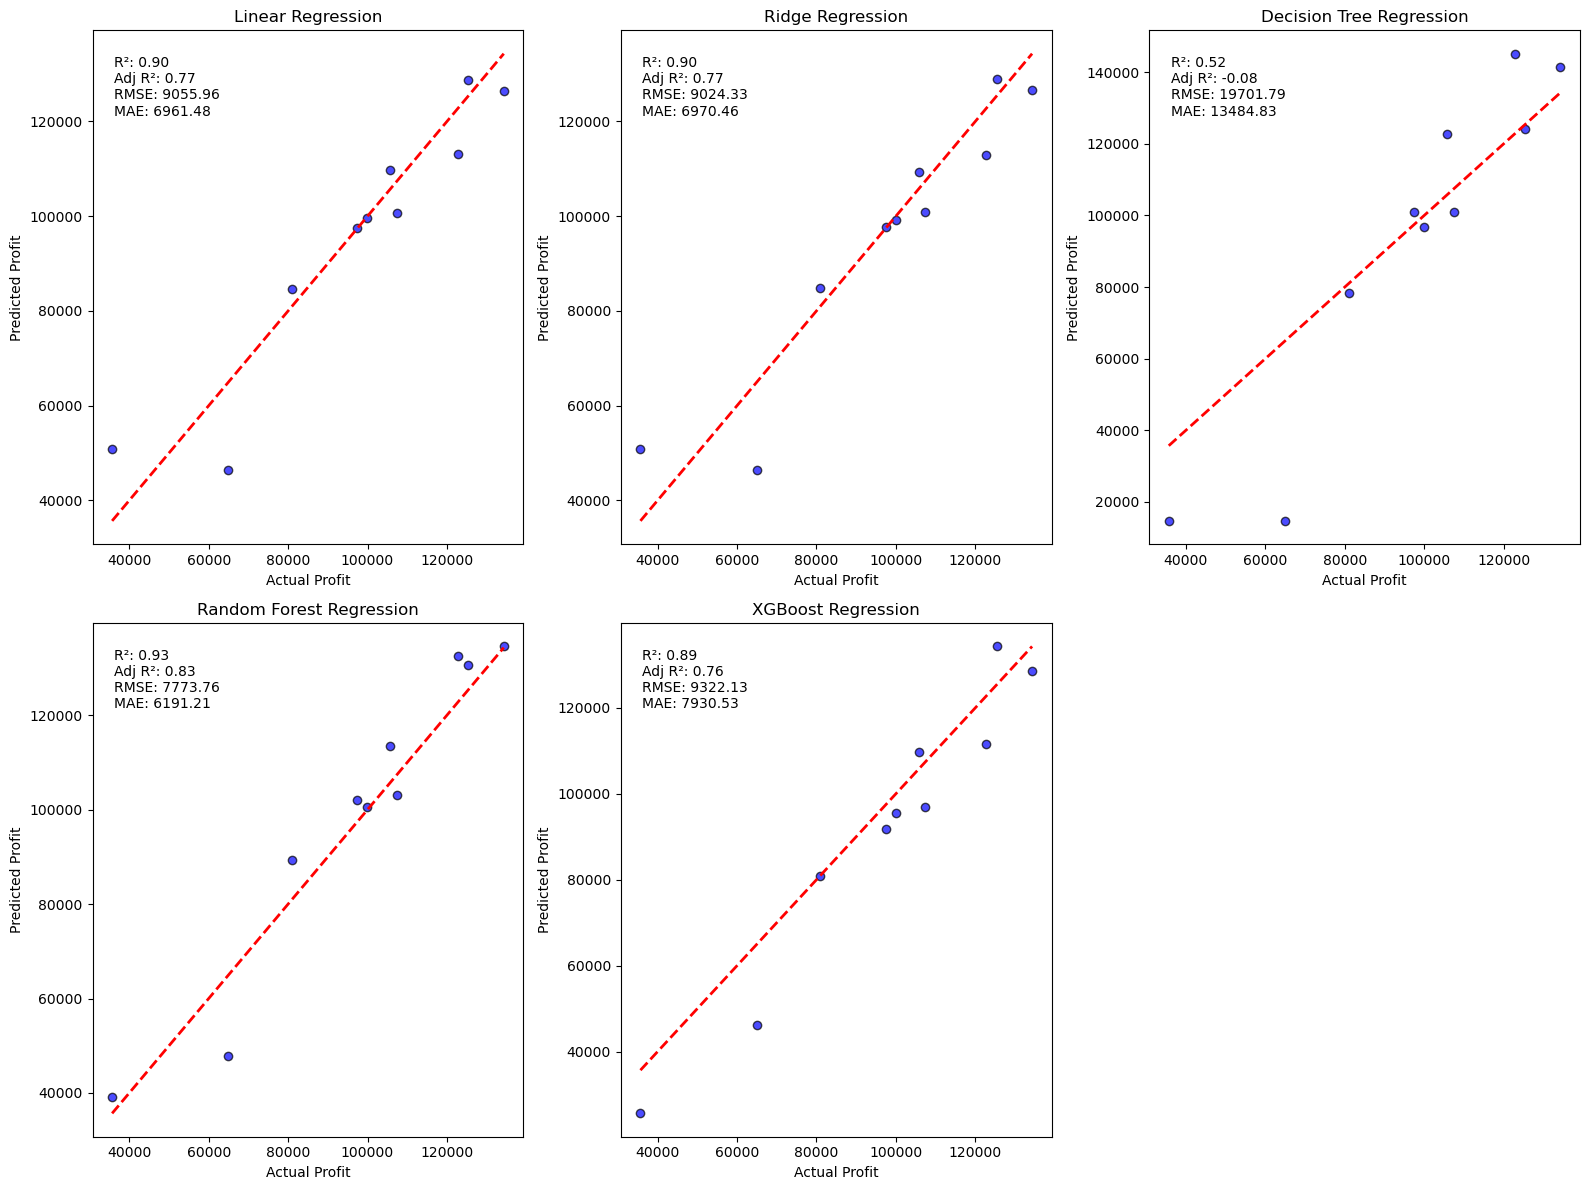

Visualization displayed successfully.


In [70]:
# Visualize Actual vs Predicted results with enhanced annotations
visualize_results(predictions, y_test, test_results)


In [71]:
# Generate and display summary table using Pandas styling
generate_results_table(y_test, predictions)

,Actual Value,Linear Regression Predicted,Ridge Regression Predicted,Decision Tree Regression Predicted,Random Forest Regression Predicted,XGBoost Regression Predicted
0,134307.35,126362.88,126603.14,141585.52,134614.97,128698.88
1,81005.76,84608.45,84808.70,78239.91,89380.68,80773.78
2,99937.59,99677.49,99271.14,96863.70,100593.26,95533.19
3,64926.08,46357.46,46342.03,14681.40,47731.36,46071.02
4,125370.37,128750.48,128880.73,124266.90,130732.16,134359.67
5,35673.41,50912.42,50859.27,14681.40,39186.81,25618.62
6,105733.54,109741.35,109370.93,122733.48,113500.06,109711.16
7,107404.34,100643.24,100820.82,101004.64,103079.48,96979.61
8,97427.84,97599.28,97701.82,101004.64,101987.09,91855.98
9,122776.86,113097.43,113021.06,145190.67,132630.22,111589.74


In [72]:
if __name__ == "__main__":
    main()

Print output is set up. All steps will be printed.
Dataset loaded successfully with shape (50, 5)
Dataset Columns: ['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit']
Dataset Head:
   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


# Model Deployment


### Saving the Random Forest model

In [75]:
import pickle

# Save the Random Forest model pipeline to a pickle file.
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(pipelines["Random Forest Regression"], file)

print("Random Forest model pipeline saved as 'random_forest_model.pkl'")


Random Forest model pipeline saved as 'random_forest_model.pkl'


### Loading and Checking the Saved Model
### --------------------------------------
- This step loads the saved Random Forest model pipeline from the pickle file,
- then prints the structure of the pipeline to confirm that it includes the necessary preprocessing and modeling steps.
- Additionally, it prints the model parameters for the Random Forest to verify that the correct configuration has
 been applied.
- This ensures that the pipeline is complete and correctly configured for making predictions on new data.


In [77]:


# Load the pickle file
with open('random_forest_model.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Print the loaded pipeline to see its structure
print("Loaded Pipeline:")
print(loaded_pipeline)

# Check the individual steps in the pipeline
print("\nPipeline steps:")
for name, step in loaded_pipeline.named_steps.items():
    print(f"{name}: {step}")

# inspect the Random Forest model parameters
print("\nRandom Forest Model Parameters:")
print(loaded_pipeline.named_steps['model'])


Loaded Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['State'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=50,
                                       random_state=42))])

Pipeline steps:
preprocessor: ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['State'])])
model: RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)

Random Forest Model Parameters:
RandomForestRegressor(max_depth=5, n_estimators=50,

### Model Prediction Test

In [79]:

sample_data = pd.DataFrame({
   'R&D Spend': [160000, 130000, 150000],
    'Administration': [130000, 120000, 140000],
    'Marketing Spend': [300000, 250000, 280000],
    'State': ['New York', 'Florida', 'California'],
    # Profit: [170000, 150000, 165000]  
})

# Run a prediction to confirm it works without error
prediction = loaded_pipeline.predict(sample_data)
print("Sample Prediction:", prediction)


Sample Prediction: [168560.40761667 151335.48391667 167069.04531667]
